<a href="https://colab.research.google.com/github/MattiaParavisi/AMD-2022-2023-project/blob/master/market_baskt_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Market Basket Analysis

In this first phase i just install pyspark and set up the spark context. There are no modifications to be done to execute the code.

In [ ]:
!pip install pyspark
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=b161fec88ecee55f37ac6ec4505f441a445bc0524a9b4ebefdc5bef3e2fbccc2
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


I proceed with the kaggle-api installation. In this phase is required to upload a .json file with kaggle username and password. After the upload phase the dataset required by the project will be automatically downloaded.

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d yelp-dataset/yelp-dataset -f yelp_academic_dataset_review.json

Saving kaggle.json to kaggle.json
100% 2.07G/2.07G [00:29<00:00, 79.2MB/s]
100% 2.07G/2.07G [00:29<00:00, 74.3MB/s]


The dataset is a .zip format, i need to uncompress it in order to make it usable. I remove the zipped file only to save space.

In [ ]:
!unzip "/content/yelp_academic_dataset_review.json" && rm *.zip

Archive:  /content/yelp_academic_dataset_review.json.zip
  inflating: yelp_academic_dataset_review.json  


# Data analysis

I can now read the json file using the spark's apis. The loading is pretty slow; this is due to the size of the file. I print also the number of rows in the dataframe obtained after the loading phase. This numer is the **number of baskets** in the market basket analysis framework. The number of baskets is pretty high: almost 7 millions.

In [ ]:
data_loader = spark.read.json("yelp_academic_dataset_review.json")

n_baskets = data_loader.count()

print(n_baskets)

6990280


The schema is the following, the field i need is the field "text" which is of type string. I can first of all try to have an idea of this field: the structure, the length and so on...

In [ ]:
data_loader.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [ ]:
data_loader.select("text").first()["text"]

"If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker."

To check if there are some rows which are null on value "text" i performed a count on that field; the COUNT() documentation specifies that only non null entries will be counted.

In [ ]:
data_loader.createOrReplaceTempView("table_text")
not_null_text = spark.sql("SELECT COUNT(`table_text`.`text`) FROM `table_text`")
not_null_text.show()

+-----------+
|count(text)|
+-----------+
|    6990280|
+-----------+



From the snippet above it's clear that the number of non-null entries is the same of the total number of rows; each row is non-null. I then computed the average length of the field, which is more or less 568 characters (not a big number but not so small on average, a tweet for example was 144 characters long).

In [ ]:
data_loader.createOrReplaceTempView("table_text")
avg_text_len = spark.sql("SELECT AVG(CHAR_LENGTH(`table_text`.`text`)) AS avg_len FROM `table_text`")
avg_text_len.show()

+-----------------+
|          avg_len|
+-----------------+
|567.7644364746477|
+-----------------+



Now that i have an idea of the size of the problem i want to do a more appropriate analysis on the number of items in the basket. In my case i will consider "item" a single word, in order to split the text field in words i could have used a regular expression, the split() method... all this methods are not so precise in the splitting operation. For this reason i decided to use a tokenizer from the library NTLK (i get this idea from the Information retrieval class), i also downloaded the punktuation set (used in the tokenization phase) and the stopword set for the language i'm considering which is english

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


I decided to create a function to tokenize a given text. In this case i return each token which is alphabetic and not in the stop words set. This decision is driven by the fact that including stop words in the basket items could lead to the definition of rules which have no relevance: stop words are words which are very frequent in the language, i expect those word to be in almost all the baskets. I return list(set(...)) because i just need to know if two words are in the same basket, i dont care about the number of times which this happen in a single basket.

In [ ]:
def tokenize(text):
  return list(set([x.strip().lower() for x in word_tokenize(text) if (x.strip().lower().isalpha()) and (x.strip().lower() not in stop_words)]))

In [ ]:
print(tokenize(data_loader.select("text").first()["text"]))

['decide', 'locations', 'bad', 'nj', 'takes', 'going', 'way', 'eat', 'experience', 'aware', 'beginning', 'long', 'experiences', 'take', 'spent', 'end', 'another', 'diner', 'pleasant', 'order', 'quicker', 'food', 'time', 'young', 'multiple', 'waitstaff', 'hours', 'come', 'tried', 'restaurant', 'want', 'weekends', 'opt', 'done', 'never', 'usually', 'good', 'many', 'waiting', 'like', 'times']


For a first try i decided to get $5 \cdot 10^5$ baskets. I decided to do this without "cheating" using the sample method. This method return a sample of the full dataframe with a given including-rate. I have to transform the dataframe in a RDD to start working in a (simulated) distributed fashion. For each of the sampled rows in the resulting dataframe i apply the tokenization function and keep only the rows with at least 2 words; i have considered "degenerate" reviews reviews like "good".



In [ ]:
num_rows = 500000
seed = 15101999
data_trial = data_loader.\
       select("text").\
       rdd.\
       sample(withReplacement=False,fraction=num_rows/n_baskets,seed=seed).\
       map(lambda row: tokenize(row["text"])).\
       filter(lambda tokenized_row: len(tokenized_row)>1).\
       cache()

I obtain an RDD in which each row is defined as a list of words. I can consider each row a basket and each element an item of the basket

In [ ]:
print(data_trial.take(2))

[['something', 'new', 'delicious', 'try', 'changed', 'naan', 'yummy', 'favorite', 'glad', 'minds', 'korma', 'go', 'curry', 'let', 'almost', 'wow', 'lamb', 'kinds', 'outside', 'deter', 'different'], ['milktooth', 'indianapolis', 'glade', 'recommended', 'experience', 'jewel', 'locals', 'chance', 'amazing']]


Now i can define the minimum support (in relative term) i want to consider a singleton/k-tuple frequent. To use the apriori algorithm i have designed i have also to rescale this relative term with respect to the number of rows i have decided to sample, this operation leads me to the definition of the support threshold.

In [ ]:
relative_thresh = 0.05
support = relative_thresh*num_rows
print(support)

25000.0


In this section i describe each support function i will use in the final A-priori implementation. The first one is **token_to_index** function, the name is self explanatory: for each token in a review i assign to it an integer number, this is useful in order to save main memory; indeed Python uses 4 bytes both for single characters and integers, using this method we can avoid to use a lot of RAM. The idea is pretty straight-forward: i define a dictionary in which i will keep the relations "token -> index", then for each token i just check if the token is in the dictionary, if not so i add it and assign as value the number of keys currently in the dictionary itself. For example i will have index 0 associated to the first value, then 1 and so on.

In [ ]:
word_to_index = {}

def token_to_index(item):
  if item not in word_to_index:
    word_to_index[item] = len(word_to_index.keys())
  return word_to_index[item]

The function index_to_token is the opposite of token_to_index. This function take a single index or a set of index and return the corresponding token.

In [ ]:
def index_to_token(val):
  res = []
  if type(val) == int:
    for key, value in word_to_index.items():
      if val == value:
        return key
  for sub_el in val:
    for key, value in word_to_index.items():
      if sub_el == value:
        res.append(key)
  return tuple(res)

The next function is generate_candidate_k_set_join; the idea for this function was taken by this [report](https://github.com/z9y1t9/SparkApriori/blob/master/5003.pdf) i found. Initially this function was more brute-forced based: i used itertools to generate the combinations of length k and then i used those combinations in order to create the next frequent subset, the problem with this approach is the number of combinations that is going to be created. In the report i linked above they have a good intuition: if we have created the following frequent singletons [1,2,3,4] we can create all the frequent couples with different elements and maintain the order: (1,2),(1,3),(1,4),(2,3),(2,4),(3,4) by doing so when we will have to create the triples we consider the first element as the key and then join if the second element of the first couple is smaller then the second element of the second couple. Let's suppose that only (1,2),(1,3),(2,3),(2,4) are frequent, then (1,2,3) (using (1,2) and (1,3)) and (2,3,4) will be the only frequent triples. This is due to the fact that for example (1,2,4) cannot be frequent because (1,4) is not in the frequent pairs. In the original implementation this function is made using "plain python", here i decided to re-write it using map reduce framework and pyspark to move the collect() command after the filtering phase.

In [ ]:
def generate_candidate_k_set_join(previous_set, k):
  if k == 2:
    mapped_prev_set = previous_set.map(lambda x : ('common_key', x))
    res_set = mapped_prev_set.join(mapped_prev_set).map(lambda x : x[1]).filter(lambda x: x == tuple(sorted(x)) and len(set(x)) > k-1)
    return res_set
  if k == 3:
    mapped_prev_set = previous_set.map(lambda x : (*x[:k-2], *x[k-2:]))
    res_set = mapped_prev_set.join(mapped_prev_set)
    return res_set
  mapped_prev_set = previous_set.map(lambda x : ((x[:k-2]), *x[k-2:]))
  res_set = mapped_prev_set.join(mapped_prev_set).map(lambda x: (*x[0], *x[1])).filter(lambda x: x == tuple(sorted(x)) and len(set(x)) > k-1)
  return res_set

The last support function for the apriori algorithm is the filter_function. This filter function is needed because using the generate_candidate_k_set_join i get a list of possible k-tuples, this k-tuples need to filtered: i have to compute the support for each tuple and filter using the support. The function takes a list of k-tuples and a review and checks if each k-tuple is in the review, if so it adds the k-tuple to a list which will be returned and flatted-out, then i will do the usual frequency-count -> filter process.

In [ ]:
def filter_function(k_tuples, indexed_element):
    indexed_set = set(indexed_element)
    res = []
    for k_tuple in k_tuples:
        if set(k_tuple).issubset(indexed_set):
            res.append(k_tuple)
    return res

In [ ]:
def apriori(data, support):

  frequent_tuples =     data \
                        .flatMap(lambda token: token) \
                        .map(lambda token : (token, 1)) \
                        .reduceByKey(lambda token_a, token_b : token_a + token_b) \
                        .filter(lambda token : token[1] > support) 
  k = 2
  frequent_elems = frequent_tuples.map(lambda token: token[0])

  while not frequent_elems.isEmpty():
    k_tuples = generate_candidate_k_set_join(frequent_elems, k).collect()
    frequent_k_tuples = data \
              .flatMap(lambda indexed_element: filter_function(k_tuples, indexed_element)) \
              .map(lambda token : (token, 1)) \
              .reduceByKey(lambda token_a, token_b : token_a + token_b) \
              .filter(lambda token : token[1] > support)
    frequent_tuples = frequent_tuples.union(frequent_k_tuples)
    frequent_elems = frequent_k_tuples.map(lambda token: token[0])
    k = k+1
  
  return frequent_tuples

I then collect all the data using spark primitives and map all the tokens to their corresponding index, i parallelize data to re-obtain an rdd. I had to do this additional steps because using directly .map(lambda x : token_to_index(x)) does not create the dictionary of associations between tokens and indexes and because i had to sample the data with the number of points i have decided above.

In [ ]:
collected_data = data_trial.collect()

In [ ]:
collected_data = [[token_to_index(token) for token in review] for review in collected_data]

In [ ]:
parallelized_data = spark.sparkContext.parallelize(collected_data)

# Execution of apriori algorithm with different thresholdes

Let's consider for example the execution of the algorithm using the parameters we had setted up until this point:
1.   Number of rows (baskets) = $5 \cdot 10^5$
2.   Relative threshold $0.05$
in this case i will consider frequent elements all the elements appearing in at least $25.000$ baskets.




In [ ]:
plot_pts = []

I take trace of the time the algorithm requires in order to be executed. I will also save the time, the threshold and the number of elements found to make a comparison at the end of the process.

In [ ]:
import time

before = time.time()

freq_set_min_thresh = apriori(parallelized_data, support) \
              .map(lambda x: (index_to_token(x[0]),x[1])) \
              .collect()

end = time.time() - before

The algorithm is able to find sensible elements. For example (the result may change one execution to the other if the seed changes) the algorithm found:


1.   food, good
2.   time, service
3.   ...

those results are pretty good, they are related to the topic of the dataset and are consistent: in a review i expect to find sentences like "the food was good" or "the food was not good" moreover i expect to find some comments about the time related to the service in a specific resturant 




In [ ]:
print(sorted(freq_set_min_thresh, key = lambda x: len(x[0]) if type(x[0]) == tuple else 1, reverse=True))

[(('food', 'good'), 75107), (('also', 'time'), 27416), (('service', 'time'), 36176), (('go', 'food'), 39430), (('go', 'great'), 32593), (('food', 'order'), 28804), (('food', 'great'), 66563), (('try', 'good'), 25267), (('like', 'good'), 46714), (('like', 'great'), 35335), (('like', 'one'), 37548), (('like', 'would'), 37364), (('good', 'great'), 54120), (('good', 'one'), 42113), (('good', 'would'), 42822), (('great', 'one'), 34409), (('great', 'would'), 34750), (('one', 'would'), 36973), (('friendly', 'place'), 25427), (('best', 'food'), 28085), (('food', 'one'), 41624), (('time', 'first'), 33924), (('time', 'get'), 38461), (('good', 'could'), 26634), (('good', 'got'), 30471), (('like', 'food'), 44696), (('go', 'good'), 38392), (('also', 'get'), 27337), (('service', 'get'), 32247), (('go', 'one'), 31561), (('go', 'would'), 33216), (('go', 'back'), 38838), (('good', 'back'), 42538), (('great', 'back'), 38014), (('one', 'back'), 34384), (('would', 'back'), 38454), (('back', 'come'), 25569

In [ ]:
print(len(freq_set_min_thresh))

275


I wanted also to check the results of the algorithm with respect to the threshold changes: i expect that when the threshold increases the number of results decreases as the execution time. This is due to the fact that the initial elements we retain will lead to a smaller number of couples, so the overall computation will be faster.

In [ ]:
plot_pts.append((relative_thresh, end, len(freq_set_min_thresh)))

In [ ]:
relative_thresh = 0.10
support = relative_thresh*num_rows

before = time.time()

second_freq_set = apriori(parallelized_data, support) \
              .map(lambda x: (index_to_token(x[0]),x[1])) \
              .collect()

end = time.time() - before

Increasing the threshold by just a 5% we get a reduction in the number of results of the 80%. This confirms what i supposed. The results are still good (they are a subset of the previous results) and they are realted to couples of items which are more frequently taken together; for example, with the threshold equal to 0.05 i found the couple ('great','back') (for example this association can appear in a review like "the place is great, i will come back"), with this new threshold this couple is not present. I can then suppose that (based on this dataset) in a number of time that is bewteen $5\% \leq x < 10\%$  of the time if a restaurant is great the costumer will come back. 

In [ ]:
print(sorted(second_freq_set, key = lambda x: len(x[0]) if type(x[0]) == tuple else 1, reverse=True))

[(('food', 'good'), 75107), (('food', 'great'), 66563), (('good', 'great'), 54120), (('service', 'great'), 54033), (('food', 'service'), 66252), (('good', 'place'), 63181), (('great', 'place'), 59971), (('food', 'place'), 68159), (('good', 'service'), 51357), ('delicious', 62779), ('also', 86142), ('even', 71645), ('friendly', 69081), ('love', 60023), ('service', 135792), ('time', 119267), ('restaurant', 55272), ('ordered', 61365), ('went', 58857), ('place', 163358), ('us', 61986), ('first', 60843), ('nice', 71616), ('get', 111367), ('well', 68508), ('people', 52129), ('came', 58578), ('staff', 70827), ('little', 55510), ('always', 58070), ('make', 50903), ('really', 86101), ('new', 51154), ('try', 57737), ('go', 101326), ('experience', 54214), ('amazing', 54333), ('like', 111764), ('best', 74516), ('food', 174974), ('good', 161160), ('order', 57129), ('great', 160123), ('never', 58947), ('one', 110904), ('definitely', 60814), ('recommend', 52651), ('much', 52768), ('would', 112038), (

In [ ]:
print(len(second_freq_set))

54


In [ ]:
plot_pts.append((relative_thresh, end, len(second_freq_set)))

In [ ]:
relative_thresh = 0.15
support = relative_thresh*num_rows

before = time.time()

freq_set = apriori(parallelized_data, support) \
              .map(lambda x: (index_to_token(x[0]),x[1])) \
              .collect()

end = time.time() - before

In [ ]:
plot_pts.append((relative_thresh, end, len(freq_set)))

In [ ]:
relative_thresh = 0.20
support = relative_thresh*num_rows

before = time.time()

freq_set = apriori(parallelized_data, support) \
              .map(lambda x: (index_to_token(x[0]),x[1])) \
              .collect()

end = time.time() - before

In [ ]:
plot_pts.append((relative_thresh, end, len(freq_set)))

In [ ]:
relative_thresh = 0.25
support = relative_thresh*num_rows

before = time.time()

freq_set = apriori(parallelized_data, support) \
              .map(lambda x: (index_to_token(x[0]),x[1])) \
              .collect()

end = time.time() - before

In [ ]:
plot_pts.append((relative_thresh, end, len(freq_set)))

In [ ]:
relative_thresh = 0.30
support = relative_thresh*num_rows

before = time.time()

freq_set = apriori(parallelized_data, support) \
              .map(lambda x: (index_to_token(x[0]),x[1])) \
              .collect()

end = time.time() - before

In [ ]:
plot_pts.append((relative_thresh, end, len(freq_set)))

In [ ]:
relative_thresh = 0.35
support = relative_thresh*num_rows

before = time.time()

freq_set = apriori(parallelized_data, support) \
              .map(lambda x: (index_to_token(x[0]),x[1])) \
              .collect()

end = time.time() - before

In [ ]:
plot_pts.append((relative_thresh, end, len(freq_set)))

In [ ]:
relative_thresh = 0.40
support = relative_thresh*num_rows

before = time.time()

freq_set = apriori(parallelized_data, support) \
              .map(lambda x: (index_to_token(x[0]),x[1])) \
              .collect()

end = time.time() - before

In [ ]:
plot_pts.append((relative_thresh, end, len(freq_set)))

In [ ]:
relative_thresh = 0.45
support = relative_thresh*num_rows

before = time.time()

freq_set = apriori(parallelized_data, support) \
              .map(lambda x: (index_to_token(x[0]),x[1])) \
              .collect()

end = time.time() - before

In [ ]:
plot_pts.append((relative_thresh, end, len(freq_set)))

In [ ]:
relative_thresh = 0.50
support = relative_thresh*num_rows

before = time.time()

freq_set = apriori(parallelized_data, support) \
              .map(lambda x: (index_to_token(x[0]),x[1])) \
              .collect()

end = time.time() - before

In [ ]:
plot_pts.append((relative_thresh, end, len(freq_set)))

In [ ]:
X,Y,Z = [list(element) for element in zip(*plot_pts)]

It's rather easy to see that as the threshold become smaller the execution time become smaller and the length of the frequent set is also smaller

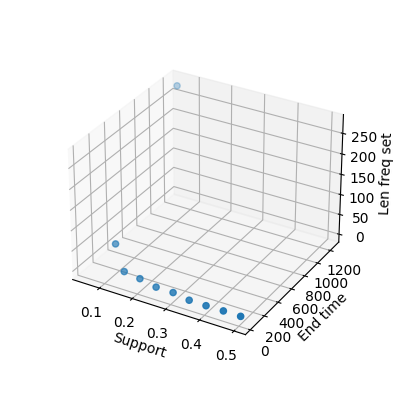

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect(aspect=None, zoom=0.8)
ax.scatter(X, Y, Z, marker='o')

ax.set_xlabel('Support')
ax.set_ylabel('End time')
ax.set_zlabel('Len freq set')

plt.show()

I tried to run this code on a databricks instance (community edition) with 1 million and a half rows and a support threshold of 0.05 and i got a result in 4004.699 seconds (1 hour more or less). The execution can be seen here:
[databricks](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/244627535523224/1264176681575531/2211219488226131/latest.html)